In [232]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = torch.arange(4, dtype=torch.float32)

In [4]:
x.sum()

tensor(6.)

In [7]:
A = torch.randint(10, (5,4))
A.shape

torch.Size([5, 4])

##### 非降维求和 [求和后保持求和矩阵维度不变]

In [24]:
sum_A = A.sum(axis=0,keepdim=True)

In [25]:
sum_A 

tensor([[19, 20, 33, 19]])

In [19]:
sum_A

tensor([[19, 20, 33, 19]])

In [22]:
A.cumsum(axis=0)

tensor([[ 1,  4,  7,  0],
        [ 3, 12, 14,  8],
        [ 5, 19, 22, 13],
        [13, 19, 26, 15],
        [19, 20, 33, 19]])

In [23]:
A

tensor([[1, 4, 7, 0],
        [2, 8, 7, 8],
        [2, 7, 8, 5],
        [8, 0, 4, 2],
        [6, 1, 7, 4]])

In [28]:
torch.norm(x)

tensor(3.7417)

In [64]:
x

tensor([0.], requires_grad=True)

In [98]:
x = torch.arange(4.0, requires_grad=True)

In [99]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [100]:
y.backward()

In [101]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [77]:
x.grad.zero_()

tensor([0., 0.])

In [78]:
x.grad

tensor([0., 0.])

#### 梯度计算

In [86]:
x = torch.tensor(2.0, requires_grad=True)

In [87]:
y = x**2
y

tensor(4., grad_fn=<PowBackward0>)

In [88]:
y.backward()

In [90]:
x.grad

tensor(4.)

In [92]:
x.grad.zero_()

tensor(0.)

In [102]:
x.grad.zero_()
y = x*x

In [103]:
y

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

In [104]:
y.sum().backward()

In [107]:
x.grad == 2*x

tensor([True, True, True, True])

##### 分离计算

In [108]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [115]:
y = x*x
y

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)

In [118]:
u = y.detach()
z = u*x
z

tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)

In [119]:
z.sum().backward()

In [130]:
x.grad == u

tensor([True, True, True, True])

##### 线性回归

In [168]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p * np.exp(-0.5/sigma**2*(x-mu)**2)

In [169]:
len([normal(x, mu, sigma) for mu, sigma in params])
len(x)

1400

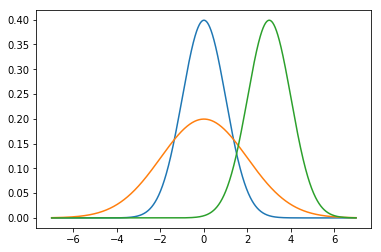

In [179]:
x = np.arange(-7,7,0.01)
params = (0,1)
plt.plot(x, normal(x, *params))
params = (0,2)
plt.plot(x, normal(x, *params))
params = (3,1)
plt.plot(x, normal(x, *params))

In [176]:
y = normal(x, 0, 1)
y.shape

(1400,)

In [233]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [234]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [244]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

In [245]:
w = torch.tensor([1., 1.], requires_grad=True)
b = torch.tensor(0., requires_grad=True)
y = torch.matmul(features, w)+b
y_pred = y.reshape((-1,1))
nn_loss = squared_loss(torch.tensor(y_pred),torch.tensor(labels))
nn_loss = nn_loss.reshape((-1,))
nn_loss.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


torch.Size([1000])

In [275]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [279]:
w = torch.tensor([1., 1.], requires_grad=True)
b = torch.tensor(0., requires_grad=True)
batch_size = 32
for i in range(10):
    for X, y in data_iter(batch_size, features, labels):
        nn_loss = squared_loss(torch.matmul(X,w)+b,y)
        nn_loss.sum().backward()
        sgd([w, b], 0.01, batch_size)
    with torch.no_grad():
        train_l = squared_loss(torch.matmul(features,w)+b, labels)
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 10.170967
epoch 2, loss 5.389756
epoch 3, loss 2.856427
epoch 4, loss 1.514318
epoch 5, loss 0.802854
epoch 6, loss 0.425676
epoch 7, loss 0.225778
epoch 8, loss 0.119768
epoch 9, loss 0.063553
epoch 10, loss 0.033743


In [310]:
net = nn.Sequential(nn.Linear(2,2), nn.Linear(2,1))
loss = nn.MSELoss()

In [311]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0., 0.])

In [312]:
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

In [313]:
for epoch in range(5):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X),y)
        ##定义的优化器会对待更新的参数梯度清零
        trainer.zero_grad() 
        l.backward()
        ##优化器通过不同的优化算法，做梯度更新
        trainer.step() 
    l = loss(net(features), labels)
    print("l is *******\n", l)

l is *******
 tensor(5.0976, grad_fn=<MseLossBackward>)
l is *******
 tensor(0.0003, grad_fn=<MseLossBackward>)
l is *******
 tensor(0.0001, grad_fn=<MseLossBackward>)
l is *******
 tensor(0.0001, grad_fn=<MseLossBackward>)
l is *******
 tensor(0.0001, grad_fn=<MseLossBackward>)
